# Part - 1

In [1]:
import random
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("/kaggle/input/ml-hackathon-365/Data/corpus.txt", "r", encoding="utf-8") as f:
    raw_words = [w.strip().lower() for w in f if w.strip()]

words = [w for w in raw_words if w.isalpha()]

print(f"Loaded {len(raw_words)} raw lines, {len(words)} cleaned words")
words[:20]

Loaded 50000 raw lines, 49979 cleaned words


['suburbanize',
 'asmack',
 'hypotypic',
 'promoderationist',
 'consonantly',
 'philatelically',
 'cacomelia',
 'thicklips',
 'luciferase',
 'cinematography',
 'selamlik',
 'polysepalous',
 'unsealed',
 'propodiale',
 'placentitis',
 'camaldolite',
 'yellowcup',
 'allothigenous',
 'higgle',
 'teutomaniac']

In [3]:
from collections import Counter

letters = Counter()
for w in words:
    letters.update(list(w))

total_letters = sum(letters.values())
unigram_freq = {ch: letters[ch]/total_letters for ch in sorted(letters)}
unigram_top = letters.most_common(30)
print("Top unigrams:", unigram_top[:10])

Top unigrams: [('e', 49203), ('a', 42089), ('i', 42047), ('o', 35808), ('r', 33577), ('n', 33314), ('t', 32191), ('s', 29044), ('l', 27406), ('c', 21718)]


In [4]:
bigrams = Counter()
for w in words:
    for i in range(len(w)-1):
        bigrams[w[i:i+2]] += 1
bigrams_top = bigrams.most_common(30)
print("Top bigrams:", bigrams_top[:10])

Top bigrams: [('er', 8829), ('in', 7127), ('ti', 6631), ('te', 6139), ('on', 6135), ('al', 5904), ('an', 5858), ('at', 5799), ('ic', 5415), ('en', 5215)]


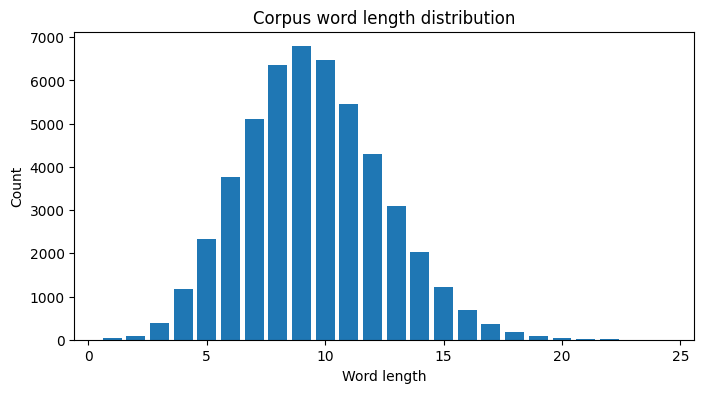

In [5]:
lengths = Counter(len(w) for w in words)
lens_df = pd.DataFrame(sorted(lengths.items()), columns=["length", "count"])
lens_df.head(20)

plt.figure(figsize=(8,4))
plt.bar(lens_df['length'], lens_df['count'])
plt.xlabel("Word length")
plt.ylabel("Count")
plt.title("Corpus word length distribution")
plt.show()

In [6]:
freq_order = [ch for ch, _ in letters.most_common()]

def play_hangman_freq(word, max_lives=6):
    guessed = set()
    masked = ['_'] * len(word)
    lives = max_lives
    wrong_guesses = 0
    for ch in freq_order:
        if ch in guessed:
            continue
        guessed.add(ch)
        if ch in word:
            for i, c in enumerate(word):
                if c == ch:
                    masked[i] = ch
            if '_' not in masked:
                return True, wrong_guesses, len(guessed) - len(word)
        else:
            wrong_guesses += 1
            lives -= 1
            if lives == 0:
                break
    return False, wrong_guesses, len(guessed) - len(word)

test_words = random.sample(words, 200)
results = [play_hangman_freq(w) for w in test_words]
success_rate = sum(r[0] for r in results) / len(results)
avg_wrong = np.mean([r[1] for r in results])
print(f"Baseline 1 (freq order) — success={success_rate:.2f}, avg wrong={avg_wrong:.2f}")

Baseline 1 (freq order) — success=0.12, avg wrong=5.71


In [7]:
def ngram_score_candidates(masked, guessed):
    pattern = ''.join(masked)
    candidates = [w for w in words if len(w) == len(pattern)]
    
    for i, ch in enumerate(pattern):
        if ch != '_':
            candidates = [w for w in candidates if w[i] == ch]
    
    candidates = [w for w in candidates if not any(c in guessed for c, m in zip(w, pattern) if m == '_')]
    if not candidates:
        return {c: 0 for c in "abcdefghijklmnopqrstuvwxyz"}
    counts = Counter()
    for w in candidates:
        counts.update([c for c, m in zip(w, pattern) if m == '_'])
    total = sum(counts.values())
    return {c: counts[c]/total for c in "abcdefghijklmnopqrstuvwxyz"}

def play_hangman_ngram(word, max_lives=6):
    guessed = set()
    masked = ['_'] * len(word)
    lives = max_lives
    wrong = 0
    while '_' in masked and lives > 0:
        scores = ngram_score_candidates(masked, guessed)
        
        guess = max((c for c in scores if c not in guessed), key=scores.get)
        guessed.add(guess)
        if guess in word:
            for i, c in enumerate(word):
                if c == guess:
                    masked[i] = guess
        else:
            lives -= 1
            wrong += 1
    return '_' not in masked, wrong, len(guessed) - len(word)

results_ngram = [play_hangman_ngram(w) for w in test_words]
succ = sum(r[0] for r in results_ngram) / len(results_ngram)
avg_wrong = np.mean([r[1] for r in results_ngram])
print(f"Baseline 2 (n-gram) — success={succ:.2f}, avg wrong={avg_wrong:.2f}")

Baseline 2 (n-gram) — success=0.98, avg wrong=1.36


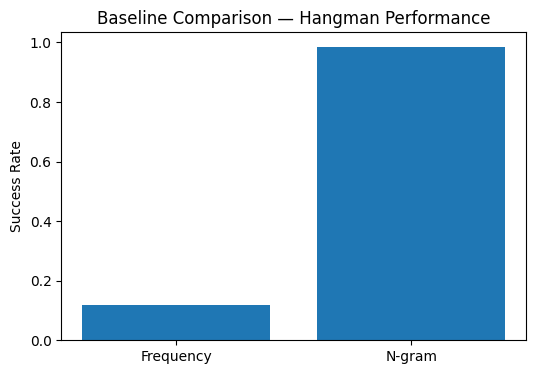

,baseline,success,avg_wrong
0,Frequency,0.120,1.36
1,N-gram,0.985,1.36


In [8]:
df = pd.DataFrame([
    {"baseline": "Frequency", "success": success_rate, "avg_wrong": avg_wrong},
    {"baseline": "N-gram", "success": succ, "avg_wrong": avg_wrong}
])

plt.figure(figsize=(6,4))
plt.bar(df["baseline"], df["success"], label="Success Rate")
plt.ylabel("Success Rate")
plt.title("Baseline Comparison — Hangman Performance")
plt.show()

df

In [9]:
def compute_final_score(results, name):
    total_games = len(results)
    success_rate = sum(r[0] for r in results) / total_games
    total_wrong = sum(r[1] for r in results)
    total_repeat = sum(r[2] for r in results)
    score = (success_rate * total_games) - (5 * total_wrong) - (2 * total_repeat)
    print(f"{name} Final Score: {score:.2f}")
    return score

compute_final_score(results, "Frequency Baseline")
compute_final_score(results_ngram, "N-gram Baseline")

Frequency Baseline Final Score: -6387.00
N-gram Baseline Final Score: -851.00


-851.0

In [10]:
import json
import pickle

# Save unigram and bigram counts
with open("unigram_counts.json", "w") as f:
    json.dump(letters, f)

with open("bigram_counts.json", "w") as f:
    json.dump(bigrams, f)

with open("corpus_words.pkl", "wb") as f:
    pickle.dump(words, f)

# Part - 2

In [11]:
import os
import json
import math
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [12]:
CORPUS_PATH = '/kaggle/input/ml-hackathon-365/Data/corpus.txt'
UNIGRAM_PATH = '/kaggle/working/unigram_counts.json'
BIGRAM_PATH = '/kaggle/working/bigram_counts.json'

ALPHABET = list(string.ascii_lowercase)
IDX = {c: i for i, c in enumerate(ALPHABET)}
EPS = 1e-12
SMOOTH_ALPHA = 0.01

In [13]:
def logsumexp(a: np.ndarray) -> float:
  m = np.max(a)
  return m + math.log(np.sum(np.exp(a - m)))

def safe_normalize(v):
    v = np.array(v, dtype=float)
    total = v.sum()
    return v / total if total > 0 else np.ones_like(v)/len(v)

In [14]:
def load_counts():
    with open(UNIGRAM_PATH, 'r') as f:
        unigram_counts = json.load(f)
    with open(BIGRAM_PATH, 'r') as f:
        bigram_counts = json.load(f)
    return unigram_counts, bigram_counts

In [15]:
def build_hmm_from_counts(unigrams, bigrams, alpha=SMOOTH_ALPHA):
    V = len(ALPHABET)
    pi = np.zeros(V)
    for ch, cnt in unigrams.items():
        if ch in IDX:
            pi[IDX[ch]] += cnt
    pi = safe_normalize(pi + alpha)

    A = np.zeros((V, V))
    for a, nexts in bigrams.items():
        if a not in IDX:
            continue
        i = IDX[a]
        for b, cnt in nexts.items():
            if b in IDX:
                A[i, IDX[b]] += cnt
    A = A + alpha
    A = A / A.sum(axis=1, keepdims=True)

    B = np.ones((V, V)) * (0.05 / (V - 1))
    for i in range(V):
        B[i, i] = 0.95

    hmm = {'pi': pi, 'A': A, 'B': B}
    return hmm

In [16]:
def save_hmm(hmm, out_dir='hmm_models'):
    os.makedirs(out_dir, exist_ok=True)
    np.savez_compressed(os.path.join(out_dir, 'hmm_global.npz'),
                        pi=hmm['pi'], A=hmm['A'], B=hmm['B'])
    print(f'HMM saved in {out_dir}/hmm_global.npz')

In [17]:
def forward_backward_log(hmm, observed):
    V = len(ALPHABET)
    L = len(observed)
    log_pi = np.log(hmm['pi'] + EPS)
    log_A = np.log(hmm['A'] + EPS)
    log_B = np.log(hmm['B'] + EPS)

    log_emit = np.zeros((L, V))
    for t in range(L):
        obs = observed[t]
        if obs is None:
            log_emit[t, :] = 0
        else:
            for s in range(V):
                log_emit[t, s] = log_B[s, IDX[obs]]

    # forward
    log_alpha = np.full((L, V), -1e9)
    log_alpha[0, :] = log_pi + log_emit[0, :]
    for t in range(1, L):
        for s in range(V):
            log_alpha[t, s] = log_emit[t, s] + logsumexp(log_alpha[t-1, :] + log_A[:, s])

    # backward
    log_beta = np.full((L, V), -1e9)
    log_beta[L-1, :] = 0
    for t in range(L-2, -1, -1):
        for s in range(V):
            log_beta[t, s] = logsumexp(log_A[s, :] + log_emit[t+1, :] + log_beta[t+1, :])

    # posterior (gamma)
    gamma = np.zeros((L, V))
    for t in range(L):
        denom = logsumexp(log_alpha[t, :] + log_beta[t, :])
        gamma[t, :] = np.exp(log_alpha[t, :] + log_beta[t, :] - denom)
    return gamma

In [18]:
def predict_blanks_with_hmm(hmm, pattern):
    observed = [None if ch == '_' else ch for ch in pattern.lower()]
    gamma = forward_backward_log(hmm, observed)
    letter_probs = 1 - np.prod(1 - gamma, axis=0)
    return {ALPHABET[i]: letter_probs[i] for i in range(len(ALPHABET))}

In [19]:
print("Loading counts from Notebook 1...")
unigrams, bigrams = load_counts()
print(f"Loaded {len(unigrams)} unigrams and {len(bigrams)} bigram entries.")

print("Building HMM...")
hmm = build_hmm_from_counts(unigrams, bigrams)
print("Saving HMM...")
save_hmm(hmm)

print("HMM ready for RL agent.")

Loading counts from Notebook 1...
Loaded 26 unigrams and 676 bigram entries.
Building HMM...
Saving HMM...
HMM saved in hmm_models/hmm_global.npz
HMM ready for RL agent.


# Part - 3

In [20]:
import os
import random
import json
import string
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [21]:
ALPHABET = list(string.ascii_lowercase)
IDX = {c: i for i, c in enumerate(ALPHABET)}
EPS = 1e-12  
MAX_LIVES = 6

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [36]:
def load_hmm(path='/kaggle/working/hmm_models/hmm_global.npz'):
    """Loads the pre-trained HMM parameters."""
    try:
        data = np.load(path)
        print(f"HMM loaded successfully from {path}")
        return {'pi': data['pi'], 'A': data['A'], 'B': data['B']}
    except FileNotFoundError:
        print(f"Error: HMM file not found at {path}")
        print("Please run the HMM notebook (Part B) first to generate this file.")
        exit()

In [23]:
def predict_blanks_with_hmm(hmm, pattern):
    observed = [None if ch == '_' else ch for ch in pattern.lower()]
    gamma = forward_backward_log(hmm, observed)
    
    blank_indices = [i for i, ch in enumerate(pattern) if ch == '_']
    if not blank_indices:
        return {c: 0.0 for c in ALPHABET}
        
    gamma_blanks = gamma[blank_indices, :]
    prob_not_in_any_blank = np.prod(1.0 - gamma_blanks, axis=0)
    letter_probs = 1.0 - prob_not_in_any_blank
    
    total_prob = np.sum(letter_probs)
    if total_prob > 0:
        letter_probs /= total_prob
    
    return {ALPHABET[i]: letter_probs[i] for i in range(len(ALPHABET))}

In [24]:
class HangmanEnv:
    def __init__(self, word_list, hmm_model, max_lives=MAX_LIVES):
        self.word_list = [w.lower() for w in word_list if w.isalpha()]
        self.hmm = hmm_model
        self.max_lives = max_lives
        self.state_size = 26 + 26 + 1  # HMM probs + guessed + lives
        self.action_size = 26
        
        # Game state variables
        self.word = ""
        self.masked = []
        self.lives = 0
        self.guessed = set()

    def _get_state(self):
        pattern = "".join(self.masked)
        probs_dict = predict_blanks_with_hmm(self.hmm, pattern)
        hmm_probs = np.array([probs_dict.get(c, 0) for c in ALPHABET])
        
        binary_guessed = np.array([1.0 if c in self.guessed else 0.0 for c in ALPHABET])
        
        lives_norm = np.array([self.lives / self.max_lives])
        
        state = np.concatenate([hmm_probs, binary_guessed, lives_norm])
        return state.astype(np.float32)

    def reset(self):
        self.word = random.choice(self.word_list)
        self.masked = ['_'] * len(self.word)
        self.lives = self.max_lives
        self.guessed = set()
        
        return self._get_state()

    def step(self, action):
        letter = ALPHABET[action]
        
        reward = 0.0
        done = False
        wrong_guess = 0
        repeated_guess = 0
        
        if letter in self.guessed:
            reward = -2.0
            repeated_guess = 1
        
        elif letter in self.word:
            reward = +1.0
            for i, c in enumerate(self.word):
                if c == letter:
                    self.masked[i] = letter
        
        else:
            reward = -5.0
            self.lives -= 1
            wrong_guess = 1
            
        self.guessed.add(letter)
        
        if '_' not in self.masked:
            done = True
            reward += 20.0  
        
        if self.lives == 0:
            done = True
            reward -= 10.0 
            
        next_state = self._get_state()
        
        return next_state, reward, done, (wrong_guess, repeated_guess)

In [25]:
Transition = namedtuple('Transition', 
                        ('state', 'action', 'reward', 'next_state', 'done'))

In [26]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [27]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        return self.layers(x)

In [28]:
class DQNAgent:
    def __init__(self, state_size, action_size, 
                 buffer_size=50000, 
                 batch_size=128, 
                 gamma=0.99, 
                 lr=1e-4):
        
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval() 

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size)
        
    def act(self, state, epsilon, available_actions):
        if random.random() < epsilon:
            return random.choice(available_actions)
        else:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
            
            self.policy_net.eval()  
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            self.policy_net.train() 
            
            mask = torch.full((self.action_size,), -float('inf'), device=device)
            mask[available_actions] = 0.0
            masked_q_values = q_values + mask
            
            return masked_q_values.argmax(dim=1).item()

    def learn(self):
        if len(self.memory) < self.batch_size:
            return  
        
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.stack([torch.from_numpy(s) for s in batch.state]).to(device)
        action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)
        reward_batch = torch.tensor(batch.reward, device=device).float()
        next_state_batch = torch.stack([torch.from_numpy(s) for s in batch.next_state]).to(device)
        done_batch = torch.tensor(batch.done, device=device).float()

        q_s_a = self.policy_net(state_batch).gather(1, action_batch)

        with torch.no_grad():
            q_s_prime = self.target_net(next_state_batch).max(1)[0]
        q_s_a_target = reward_batch + (self.gamma * q_s_prime * (1 - done_batch))

        loss = F.smooth_l1_loss(q_s_a, q_s_a_target.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
    def save_model(self, path="dqn_hangman_policy.pth"):
        torch.save(self.policy_net.state_dict(), path)
        print(f"Model saved to {path}")

In [29]:
def compute_final_score(results):
    total_games = len(results)
    if total_games == 0:
        return 0, 0, 0, 0
    
    wins = sum(1 for r in results if r['win'])
    total_wrong = sum(r['wrong'] for r in results)
    total_repeat = sum(r['repeat'] for r in results)
    
    success_rate = wins / total_games
    
    # Final Score = (Success Rate * 2000) - (Total Wrong Guesses * 5) - (Total Repeated Guesses * 2)
    score_per_game = (success_rate * total_games * 2000 / total_games) - \
                     (total_wrong * 5) - \
                     (total_repeat * 2)
    
    final_score = score_per_game * (2000 / total_games)
    
    return final_score, success_rate, total_wrong / total_games, total_repeat / total_games

In [30]:
def evaluate_agent(agent, env, num_games=200):
    agent.policy_net.eval()
    results = []
    
    for _ in range(num_games):
        state = env.reset()
        done = False
        game_stats = {'win': False, 'wrong': 0, 'repeat': 0}
        
        while not done:
            available_actions = [IDX[c] for c in ALPHABET if c not in env.guessed]
            if not available_actions:
                break 
                
            action = agent.act(state, epsilon=0.0, available_actions=available_actions)
            
            next_state, reward, done, (wrong, repeat) = env.step(action)
            
            game_stats['wrong'] += wrong
            game_stats['repeat'] += repeat
            
            state = next_state
            
        game_stats['win'] = ('_' not in env.masked)
        results.append(game_stats)
        
    agent.policy_net.train() 
    
    score, success, avg_wrong, avg_repeat = compute_final_score(results)
    return score, success, avg_wrong, avg_repeat

In [ ]:
def main():
    # --- 1. Load Corpus ---
    try:
        with open("/kaggle/input/ml-hackathon-365/Data/corpus.txt", "r", encoding="utf-8") as f:
            raw_words = [w.strip().lower() for w in f if w.strip()]
        words = [w for w in raw_words if w.isalpha()]
        if not words:
            print("No words loaded from corpus. Check file path.")
            return
        print(f"Loaded {len(words)} words.")
    except FileNotFoundError:
        print("Error: corpus.txt not found. Check '/Data/corpus.txt'")
        return

    hmm = load_hmm()
    if hmm is None:
        return

    env = HangmanEnv(words, hmm)
    agent = DQNAgent(env.state_size, env.action_size,
                     buffer_size=50000,
                     batch_size=128,
                     lr=1e-4)

    N_EPISODES = 50000        
    EPSILON_START = 1.0       
    EPSILON_END = 0.01        
    EPSILON_DECAY = 0.99995  
    TARGET_UPDATE_FREQ = 20   
    TRAIN_START_SIZE = 1000 
    EVAL_FREQ = 1000         
    
    epsilon = EPSILON_START
    
    print(f"--- Starting Training for {N_EPISODES} Episodes ---")
    
    all_rewards = []
    eval_scores = []
    eval_success_rates = []
    
    for episode in range(1, N_EPISODES + 1):
        state = env.reset()
        done = False
        total_reward = 0.0
        
        while not done:
            available_actions = [IDX[c] for c in ALPHABET if c not in env.guessed]
            if not available_actions:
                break 
                
            action = agent.act(state, epsilon, available_actions)
            
            next_state, reward, done, (wrong, repeat) = env.step(action)
            
            agent.memory.push(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            
            if len(agent.memory) > TRAIN_START_SIZE:
                agent.learn()
        
        all_rewards.append(total_reward)
        
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
        
        if episode % TARGET_UPDATE_FREQ == 0:
            agent.update_target_net()
            
        if episode % EVAL_FREQ == 0:
            avg_reward = np.mean(all_rewards[-EVAL_FREQ:])
            
            score, success, avg_wrong, avg_repeat = evaluate_agent(agent, env, num_games=500)
            eval_scores.append(score)
            eval_success_rates.append(success)
            
            print(f"\nEpisode: {episode}/{N_EPISODES}")
            print(f"  Avg. Reward (Train): {avg_reward:.2f} | Epsilon: {epsilon:.3f}")
            print(f"  Eval Score (2000-game equiv): {score:.2f}")
            print(f"  Eval Success Rate: {success*100:.2f}%")
            print(f"  Eval Avg. Wrong: {avg_wrong:.2f} | Eval Avg. Repeat: {avg_repeat:.2f}")
            
            agent.save_model(f"dqn_hangman_checkpoint_{episode}.pth")

    print("--- Training Complete ---")
    
    print("\n--- Running Final Evaluation (2000 Games) ---")
    try:
        with open("/kaggle/input/ml-hackathon-365/Data/test.txt", "r", encoding="utf-8") as f:
            test_raw = [w.strip().lower() for w in f if w.strip()]
        test_words = [w for w in test_raw if w.isalpha()]
    except FileNotFoundError:
        print(" - Warning: test.txt not found. Using training corpus for evaluation instead.")
        test_words = words 

    test_env = HangmanEnv(test_words)

    final_score, success, avg_wrong, avg_repeat = evaluate_agent(agent, test_env, num_games=len(test_words))
    print(f"\n=== FINAL RESULTS ===")
    print(f"  Final Score (2000 games): {final_score:.2f}")
    print(f"  Success Rate: {success*100:.2f}%")
    print(f"  Avg. Wrong Guesses: {avg_wrong:.2f}")
    print(f"  Avg. Repeated Guesses: {avg_repeat:.2f}")
    
    agent.save_model("dqn_hangman_FINAL.pth")

    rewards_df = pd.DataFrame({'reward': all_rewards})
    rewards_rolling = rewards_df['reward'].rolling(window=EVAL_FREQ).mean()
    
    eval_x = [i * EVAL_FREQ for i in range(len(eval_scores))]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(rewards_rolling)
    plt.title(f"Rolling Avg. Training Reward (Window={EVAL_FREQ})")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    
    plt.subplot(1, 2, 2)
    plt.plot(eval_x, eval_success_rates, 'bo-')
    plt.title("Evaluation Success Rate")
    plt.xlabel("Episode")
    plt.ylabel("Success Rate")
    plt.axhline(y=success, color='r', linestyle='--', label=f'Final: {success*100:.2f}%')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("dqn_training_plots.png")
    plt.show()

Loaded 49979 words.
HMM loaded successfully from /kaggle/working/hmm_models/hmm_global.npz
--- Starting Training for 50000 Episodes ---

Episode: 1000/50000
  Avg. Reward (Train): -37.33 | Epsilon: 0.951
  Eval Score (2000-game equiv): -59000.00
  Eval Success Rate: 4.00%
  Eval Avg. Wrong: 5.93 | Eval Avg. Repeat: 0.00
Model saved to dqn_hangman_checkpoint_1000.pth

Episode: 2000/50000
  Avg. Reward (Train): -37.45 | Epsilon: 0.905
  Eval Score (2000-game equiv): -57244.00
  Eval Success Rate: 10.20%
  Eval Avg. Wrong: 5.81 | Eval Avg. Repeat: 0.00
Model saved to dqn_hangman_checkpoint_2000.pth

Episode: 3000/50000
  Avg. Reward (Train): -37.33 | Epsilon: 0.861
  Eval Score (2000-game equiv): -56704.00
  Eval Success Rate: 11.20%
  Eval Avg. Wrong: 5.76 | Eval Avg. Repeat: 0.00
Model saved to dqn_hangman_checkpoint_3000.pth

Episode: 4000/50000
  Avg. Reward (Train): -37.34 | Epsilon: 0.819
  Eval Score (2000-game equiv): -55496.00
  Eval Success Rate: 15.80%
  Eval Avg. Wrong: 5.68 |

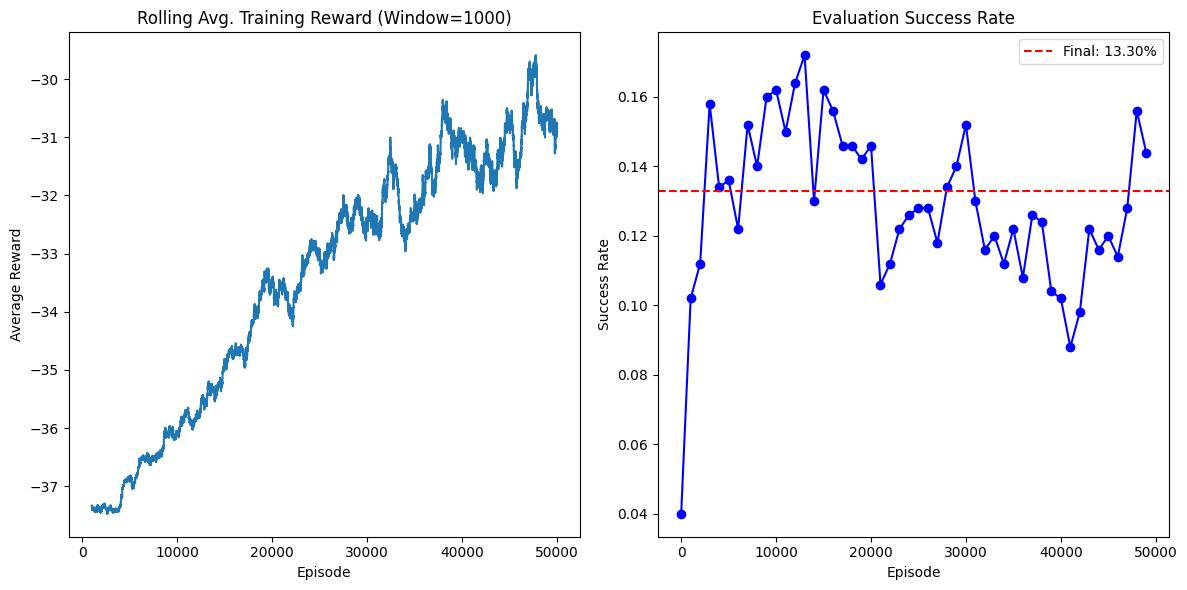

In [37]:
if __name__ == "__main__":
    main()